In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
import datetime
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm


Using TensorFlow backend.


In [2]:
from astrohack import *
import astrohack

In [3]:
x = 128+16+4
if x & 16:
    print("a")

a


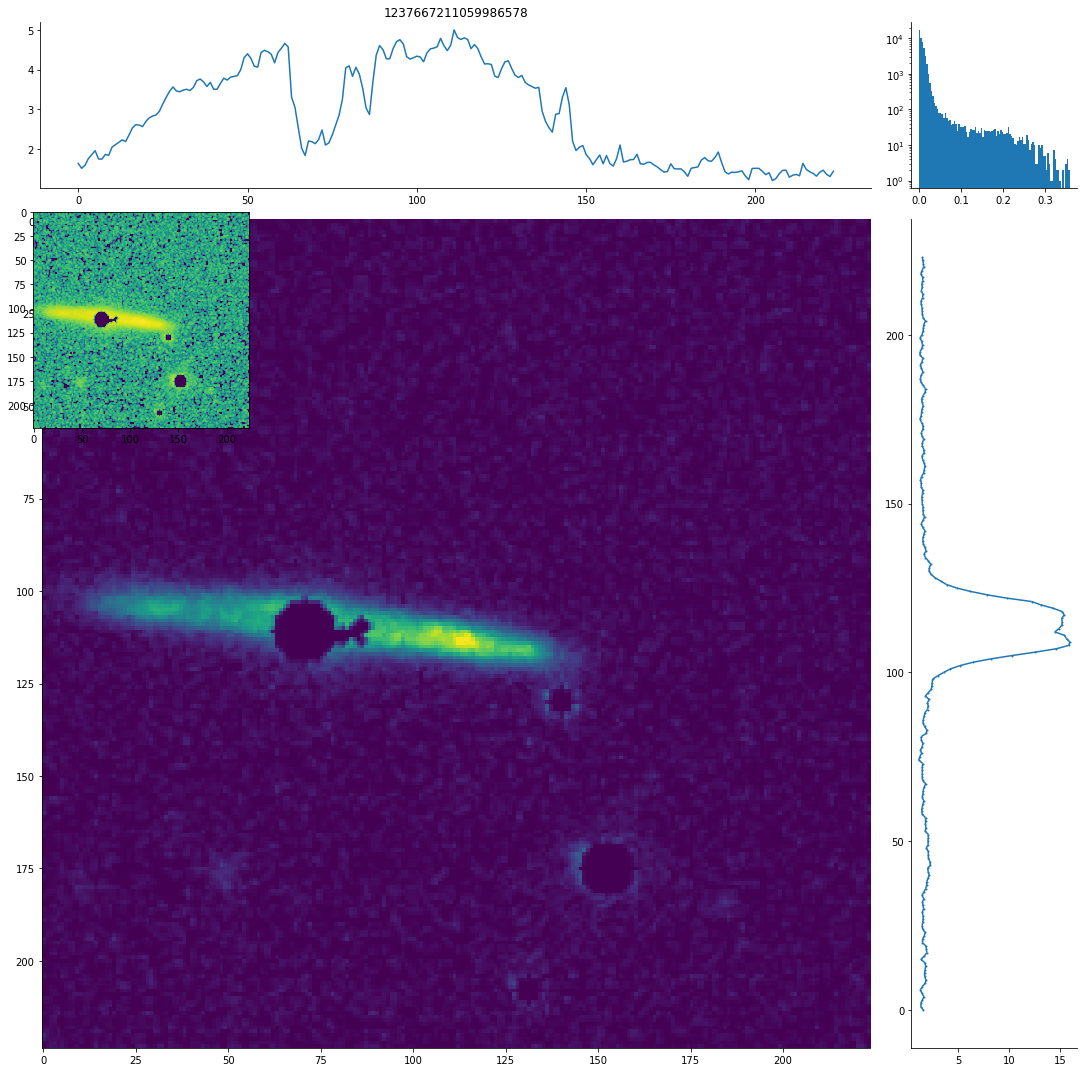

In [4]:
astrohack.dataFolder = 'data/mainData/'
astrohack.dataFolder = 'data/mainData_original/'

X = read_image('1237667211059986578')
X = cleanupImage(X)
X = img_preprocnoread(X, 1) 
X = img_preproc(1237667211059986578,79)
# plt.imshow(img_preproc('1237667211059986578', 16+32+64))
# plt.show()
# 1 for vlip
# 2 for hflip
# 4 for rotate90
# 8 for scale[0,1]
# 16 for log1p
# 32  for normalize ([-mean/std])
# 64 for crop
# 128 hackaton cleanup

drawOneGalaxy(1237667211059986578,128+16+4+2)

# score = xi2(truth, pred, error)



### Read metadata file

In [5]:
df = getAstrohackDataFrame()

df.head()

,SDSS_ID,RA,DEC,D25,redshi,GalSize_kpc,D_Mpc,d_pix_kpc,ML_g,ML_i,ML_g_rel_err,ML_i_rel_err,logMstar,err_logMstar,Distance,lin_mass,lin_err,hasFile
174,1237662301367173202,231.31860,41.34601,0.512861,0.0761,48.655727,326.142854,0.632474,2.472975,2.279201,0.105385,0.10490392881262686,10.325,0.045,326.142854,2.113489e+10,2.189920e+09,True
216,1237662301905813735,236.00985,39.28830,0.446684,0.0685,38.145197,293.571417,0.569310,0.841365,1.148099,0.093758,0.09498951605786418,9.824,0.040,293.571417,6.668068e+09,6.141517e+08,True
237,1237662534360301834,237.49500,9.27861,0.630957,0.0390,30.677076,167.142861,0.324133,0.703785,1.051369,0.122754,0.12327084107474802,9.923,0.053,167.142861,8.375293e+09,1.022096e+09,True
276,1237662500543987740,242.00880,36.05398,0.562341,0.0658,46.129129,282.000016,0.546870,1.248502,1.269311,0.183377,0.1837691489095808,10.356,0.079,282.000016,2.269865e+10,4.128980e+09,True
332,1237662474232398001,246.28905,29.94774,0.446684,0.0455,25.337321,194.999996,0.378155,0.419816,0.559744,0.219920,0.2194701990290622,9.234,0.094,194.999996,1.713957e+09,3.709741e+08,True


![title](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [6]:
import keras

from keras.layers import Input, Dense, Lambda, Layer, Conv2D, MaxPooling2D,UpSampling2D, concatenate
from keras.models import Model
from keras import backend as K
from keras import metrics

imgsize = 224

def uconvx2(x, channels):
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
    x = Conv2D(channels, (3,3), activation='relu', padding='same')(x)
    return x

def uConvDown(x, channels):
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = uconvx2(x, channels)
    return x

def uConvUp(x, grey, channels):
    x = UpSampling2D((2, 2))(x)
    x = uconvx2(concatenate([x,grey]), channels)
    return x

inp = Input(shape=(imgsize,imgsize,1), name='input')

startChannel = 64
numChannels = 4
layer = []

layer.append(uconvx2(inp, startChannel))
for i in range(1, numChannels+1):
    layer.append(uConvDown(layer[-1],startChannel*(2**i)))

middle = layer[-1]

for i in range(numChannels+1,1,-1):
    layer.append(uConvUp(layer[-1], layer[i-2], startChannel*(2**i)))
#     layer.append(uConvUp(layer[-1],startChannel*(2**i)))

out = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(layer[-1])


mid = Model(inp, middle)
unetAE = Model(inp,out)
unetAE.compile(optimizer='adadelta', loss='binary_crossentropy')

unetAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, 224, 224, 1)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 224, 224, 64)  640         input[0][0]                      
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 224, 224, 64)  36928       conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 112, 112, 64)  0           conv2d_2[0][0]                   
___________________________________________________________________________________________

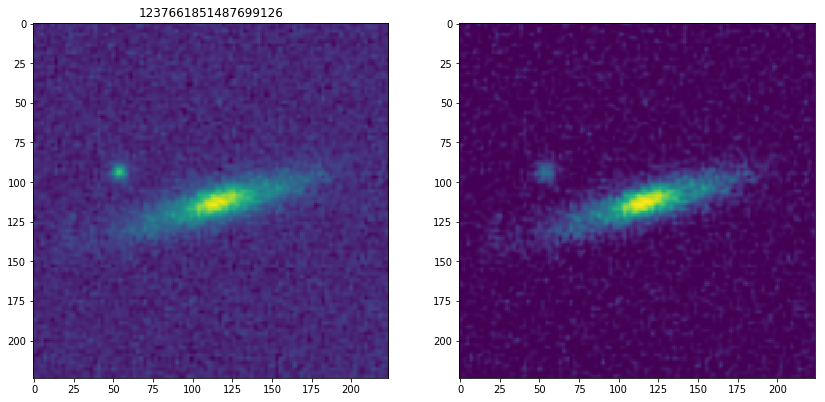

Epoch 1/5
3/3 [==============================] - 0s - loss: 0.1295
Epoch 2/5
3/3 [==============================] - 0s - loss: 0.1288
Epoch 3/5
3/3 [==============================] - 0s - loss: 0.1286
Epoch 4/5
3/3 [==============================] - 0s - loss: 0.1285
Epoch 5/5


KeyboardInterrupt: 

In [10]:
chunkSize = 3

# 1 for vlip
# 2 for hflip
# 4 for rotate90
# 8 for scale[0,1]
# 16 for log1p
# 32  for normalize ([-mean/std])
# 64 for crop
# 128 hackaton cleanup
curPreProc = 64+16+8
# for i in range(0, int(len(train.SDSS_ID)*1), chunkSize):
for i in range(200, 20000, chunkSize):
    x_train = np.stack([ img_preproc(x,curPreProc) for x in df.SDSS_ID.values[i: (i + chunkSize)]])
    y_train = np.stack([ img_preproc(x,curPreProc+128) for x in df.SDSS_ID.values[i: (i + chunkSize)]])
    x_train = x_train[:, :, :, newaxis]
    y_train = y_train[:, :, :, newaxis]

    if ( i%2 == 0):
        clear_output(wait=True)
        imgid = df.SDSS_ID.values[random.randint(0, df.shape[0]-1)]

        testimg = img_preproc(imgid,curPreProc)
        testimga = testimg[newaxis, :,:,newaxis]

        plt.figure(figsize=(14,14))
        plt.subplot(121)
        plt.title(str(imgid))
        plt.imshow(testimg)
        plt.subplot(122)
        plt.imshow(unetAE.predict(testimga)[0,:,:,0])
        plt.show()

    unetAE.fit(x_train, y_train,
                epochs=5,
                batch_size=chunkSize,
                shuffle=True,
#                 validation_data=(x_test, x_test),
                    verbose=1
#                 ,callbacks=[plot_losses]
              )

    
unetAE.save("unetcleanup" + str(datetime.now()))

In [14]:
import datetime

In [16]:
unetAE.save("unetcleanup1")

In [ ]:
x_train.shape
plt.imshow(x_train[0][:,:,0])

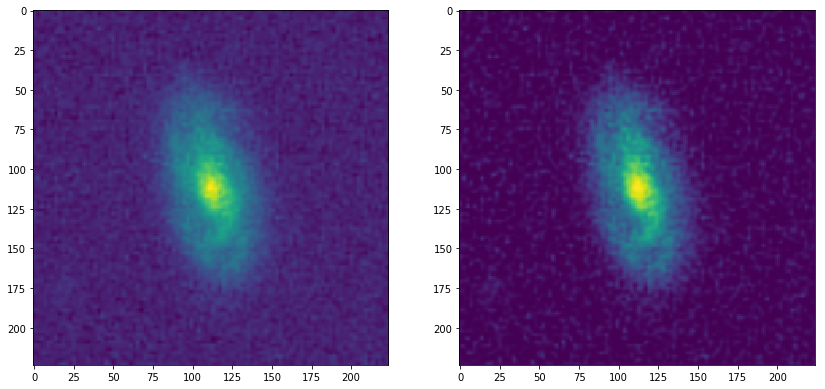

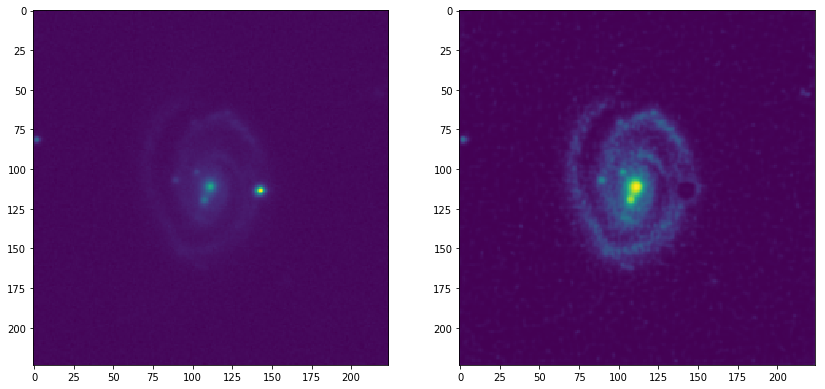

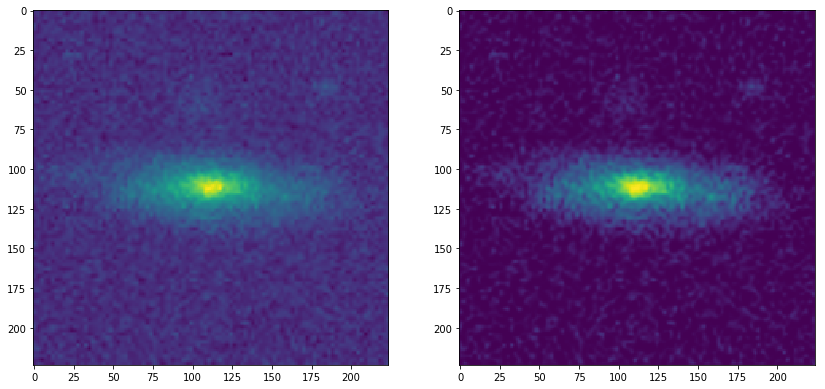

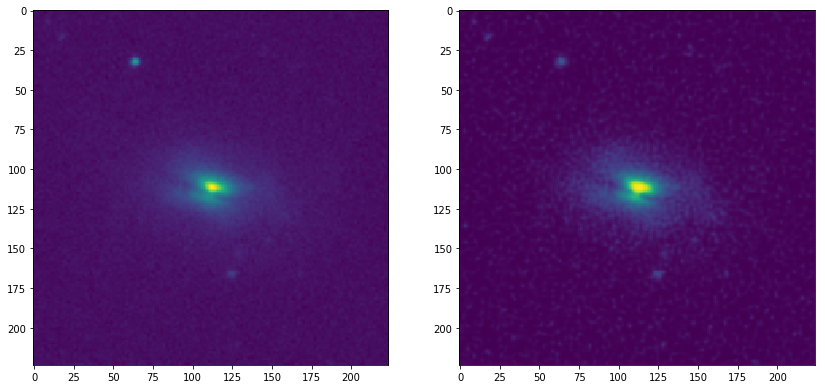

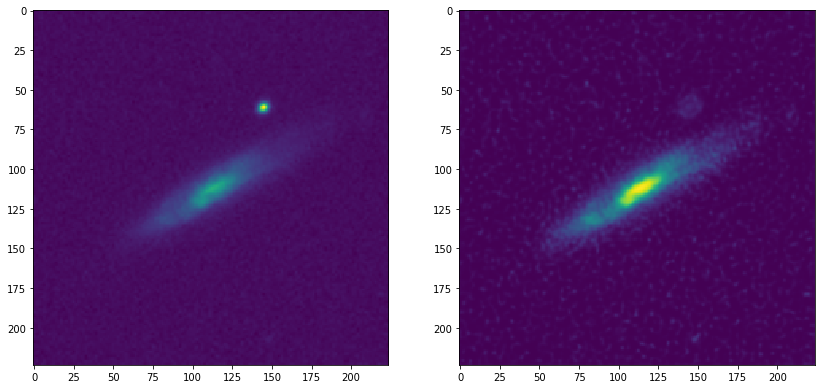

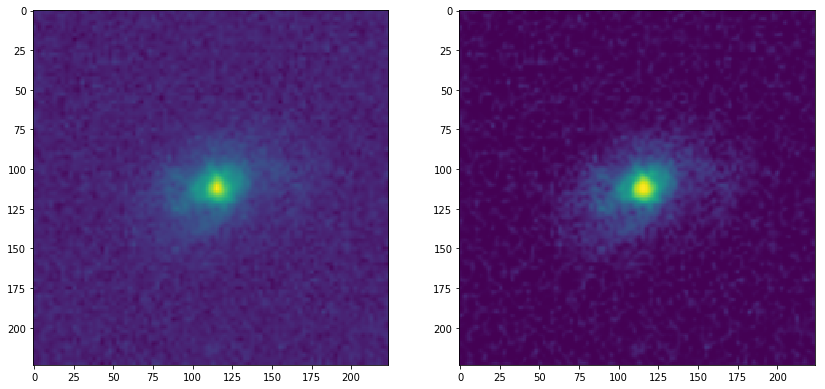

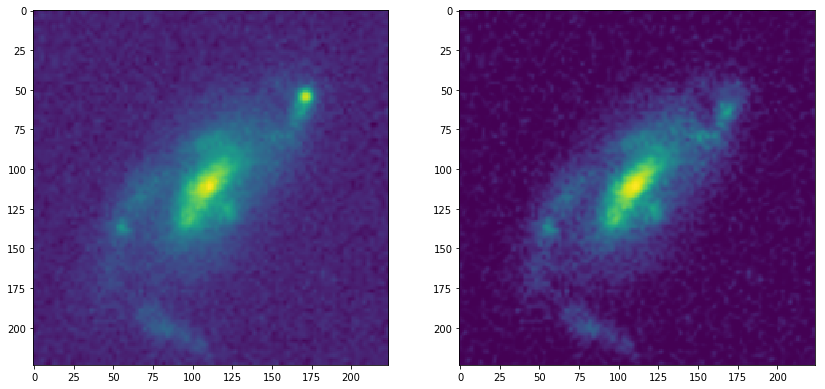

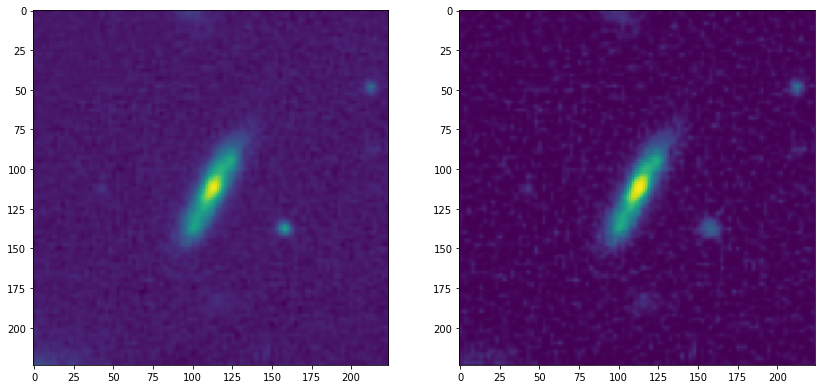

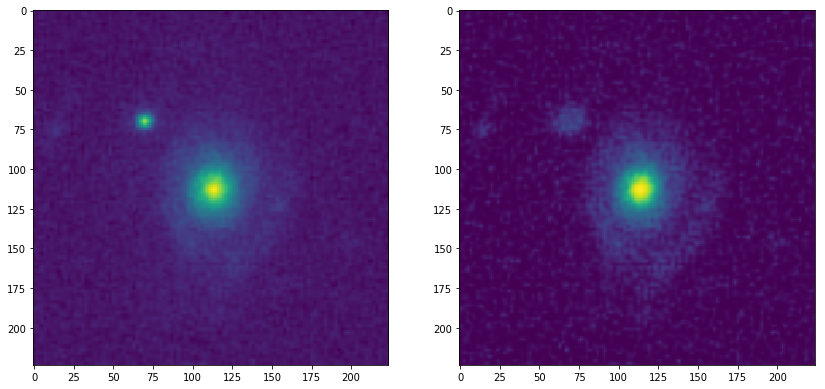

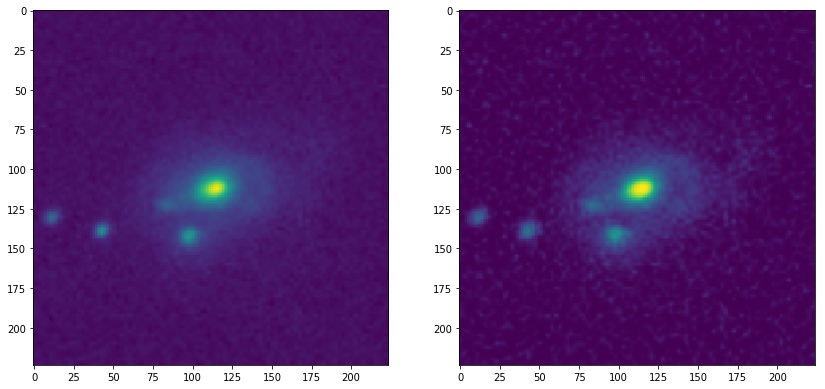

In [22]:
curPreProc = 64+16+8

for _ in range(10):
    imgid = df.SDSS_ID.values[random.randint(0, df.shape[0]-1)]

    testimg = img_preproc(imgid,curPreProc)
    testimga = testimg[newaxis, :,:,newaxis]

    plt.figure(figsize=(14,14))
    plt.subplot(121)
    plt.imshow(testimg)
    plt.subplot(122)
    plt.imshow(unetAE.predict(testimga)[0,:,:,0])
    plt.show()

In [ ]:
plt.imshow(unetAE.predict(x_train)[0,:,:,0])